# Kr analysis (run 3389)

# Notebook configuration

In [74]:
outputfolder  = "plots/"
save_plots    = False
inputfilename = "/Users/Gonzalo/github/NEXTdata/Na22/NaTracksNaPE2.h5"

In [75]:
from __future__ import print_function, division

import os
import functools
import textwrap
import time
import glob
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf

pi = np.pi

coref = fitf

Running on  Fri Apr 21 11:46:03 2017


#### General plotting options

In [76]:
%matplotlib inline

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
XR1Opt  = "k"
XR2Opt  = "c"

if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [77]:
def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values, ene=29.6):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (ene/2458)**0.5

def gausstext(values, ene=29.6):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values, ene)))

def save_to_folder(save_plots, outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    if save_plots:
        plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

save = functools.partial(save_to_folder, save_plots, outputfolder)

### Input data

In [78]:
ifile = os.path.expandvars(inputfilename)
print("ifile:", ifile)

ifile: /Users/Gonzalo/github/NEXTdata/Na22/NaTracksNaPE2.h5


# Read data

In [79]:
full = dstf.load_dst(ifile, "DST", "Tracks")
group = full.groupby(["event","npeak"])

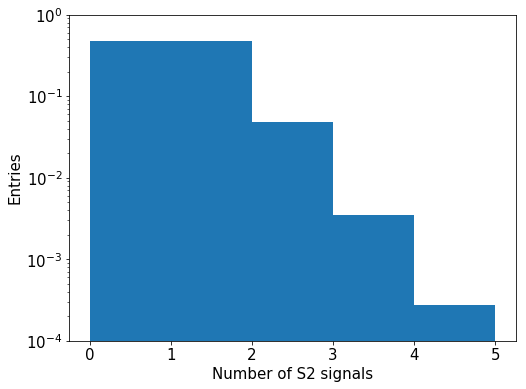

In [80]:
pdf(group.npeak.max(), 5, (0,5))
labels("Number of S2 signals", "Entries")

[  6.37600708e+05   7.08679600e+03   4.83913235e+02] (16.046688812724657, 1.760922922500493)


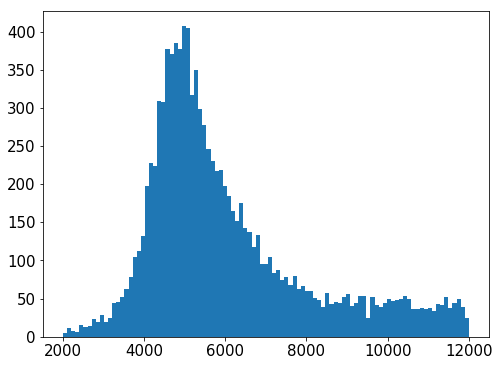

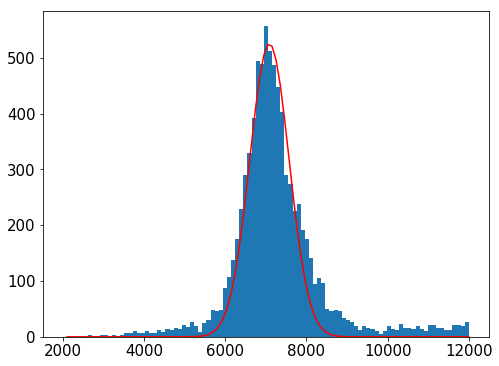

In [81]:
Ebins = np.linspace(2e3, 12e3, 100)
y, x, _ = hist(group.E.sum()    , Ebins)
y, x, _ = hist(group.Ecorr.sum(), Ebins); x = x[:-1] + np.diff(x)
f = fitf.fit(fitf.gauss, x, y, (1e6, 7e3, 3e2), fit_range=(6500, 7800))
plt.plot(x, f.fn(x), "r-")
print(f.values, reso(f.values))

[  6.01151862e+06   1.14275654e+05   5.48409096e+03   8.32087479e+02
  -5.48354328e-03] (11.277654796092124, 5.1420738268017745)


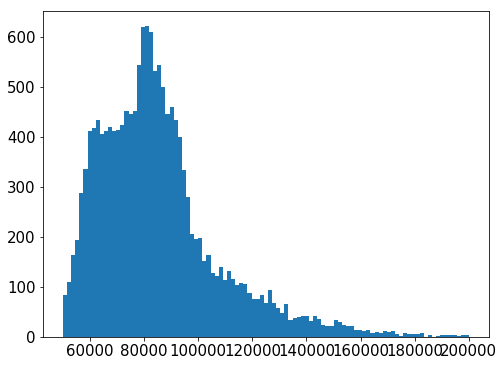

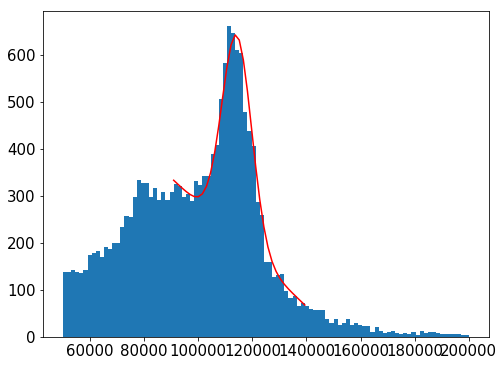

In [94]:
Ebins = np.linspace(5e4, 20e4, 100)
y, x, _ = hist(group.E.sum()    , Ebins)
y, x, _ = hist(group.Ecorr.sum(), Ebins); x = x[:-1] + np.diff(x)

fit_range = 90e3,140e3
fitfun = lambda x, g, mu, sig, a, b: fitf.gauss(x, g, mu, sig) + fitf.expo(x, a, b)
fitfun = lambda x, g, mu, sig, a, b: fitf.gauss(x, g, mu, sig) + fitf.polynom(x, a, b)
f = fitf.fit(fitfun, x, y, (1e7, 120e3, 3e3, 1e4, -1e4), fit_range=fit_range)
#f = fitf.fit(fitf.gauss, x, y, (1e7, 120e3, 3e3), fit_range=(110e3, 130e3))
sel = fitf.in_range(x, *fit_range)
plt.plot(x[sel], f.fn(x[sel]), "r-")
print(f.values, reso(f.values[:3], 511))

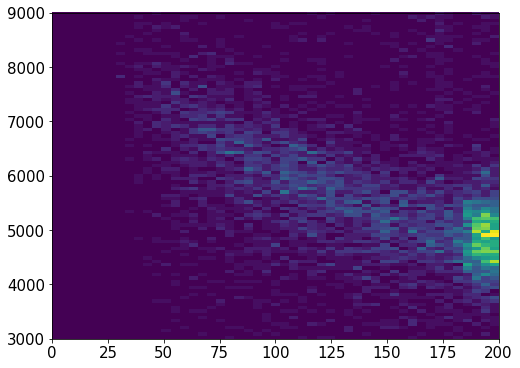

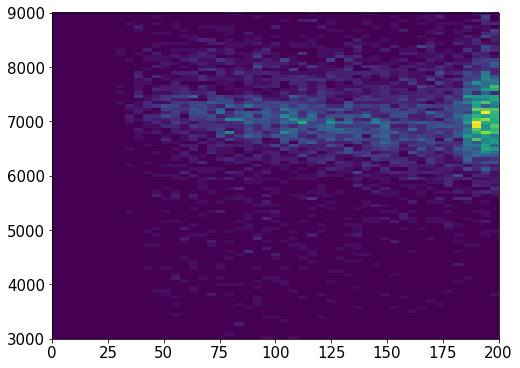

In [95]:
Zbins = np.linspace(  0, 200,  50)
Ebins = np.linspace(3e3, 9e3, 100)
hist2d(group.Z.mean(), group.E.sum()    , (Zbins, Ebins))
hist2d(group.Z.mean(), group.Ecorr.sum(), (Zbins, Ebins));

In [135]:
group2 = group.filter(lambda g: g.X.mean()**2 + g.Y.mean()**2 < 180**2).groupby(["event", "npeak"])\
              .filter(lambda g: 100e3 < g.Ecorr.sum() < 120e3)         .groupby(["event", "npeak"])


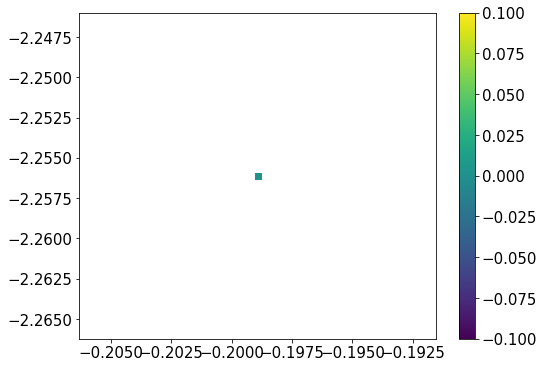

In [136]:
group2 = group.filter(lambda g: g.X.mean()**2 + g.Y.mean()**2 < 180**2)
profile_and_scatter(group2.X.mean(), group2.Y.mean(), group2.Ecorr.sum(), (50, 50));
#hist2d(group.Z.mean(), group.E.sum()    , (Zbins, Ebins))

/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:102: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  34.71920215    2.65618208  541.94961372]
[ 0.97505239  0.28951076  0.04947738]


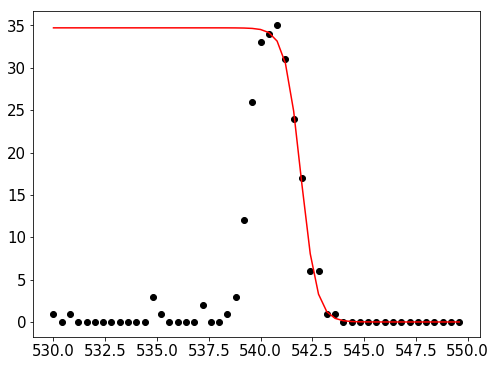

In [69]:
y = np.array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   3.,   1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   1.,
         3.,  12.,  26.,  33.,  34.,  35.,  31.,  24.,  17.,   6.,   6.,
         1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.])
x = np.array([ 530. ,  530.4,  530.8,  531.2,  531.6,  532. ,  532.4,  532.8,
        533.2,  533.6,  534. ,  534.4,  534.8,  535.2,  535.6,  536. ,
        536.4,  536.8,  537.2,  537.6,  538. ,  538.4,  538.8,  539.2,
        539.6,  540. ,  540.4,  540.8,  541.2,  541.6,  542. ,  542.4,
        542.8,  543.2,  543.6,  544. ,  544.4,  544.8,  545.2,  545.6,
        546. ,  546.4,  546.8,  547.2,  547.6,  548. ,  548.4,  548.8,
        549.2,  549.6,  550. ])[:-1]
plt.plot(x, y, "ok")
fun = lambda x, a, b, c: a/(1+np.exp(b*(x-c)))
f = fitf.fit(fun, x, y, (35, 10 ,540), fit_range=(540, 545))
plt.plot(x, f.fn(x), "r-")
print(f.values)
print(f.errors)